<a href="https://colab.research.google.com/github/jonad/pytorch_mlflow/blob/master/textclassification_with_mlflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Packaging a Pytorch Model Using MLFLOW

### Introduction

In this notebook, I will demonstrate the steps involved in building a text classification model in PyTorch and packaging it using [MLflow Models](www.mlflow.org/docs/latest/models.html).

### Dataset

The dataset used in this notebook is a subset of this [Kaggle Competition](https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification). I have selected about 50000 datapoints. 

In [0]:
#useful import
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
# import package
import pandas as pd
import warnings
from tqdm import tqdm, notebook
import random
import os
import torch
import numpy as np
import gc
from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer
from torch import nn
from torch.utils import data
from torch.nn import functional as F
import time

notebook.tqdm.pandas()
warnings.filterwarnings('ignore')

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()

train = pd.read_csv('/content/drive/My Drive/jsaw/minijisaw.csv')

In [28]:
train.head()

,Unnamed: 0,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,1219341,5605493,0.0,The cause of the Ashcroft Reserve fire is unde...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-07-17 05:25:39.587035+00,54,5605272.0,355993,approved,0,0,0,6,0,0.0,0,4
1,696666,4974622,0.0,Would you like fries with your Nietzsche?,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-03-08 06:28:38.365785+00,54,NaN,317415,approved,4,0,0,0,0,0.0,0,4
2,1440915,5880795,0.0,"I'm going to join all the Trumpists here, and ...",0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-09-01 18:33:26.643885+00,55,NaN,373180,approved,0,0,0,0,0,0.0,0,4
3,1262489,5657909,0.0,I don't think the answer here is throwing arou...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-07-25 23:41:52.826250+00,54,NaN,359281,approved,0,1,2,36,1,0.0,0,4
4,1398136,5827263,0.2,I could not agree with you more. Admiral Auco...,0.0,0.0,0.2,0.2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017-08-23 20:23:53.862711+00,55,5824993.0,369582,approved,0,1,0,0,0,0.0,4,5


In [29]:
train.columns

Index(['Unnamed: 0', 'id', 'target', 'comment_text', 'severe_toxicity',
       'obscene', 'identity_attack', 'insult', 'threat', 'asian', 'atheist',
       'bisexual', 'black', 'buddhist', 'christian', 'female', 'heterosexual',
       'hindu', 'homosexual_gay_or_lesbian',
       'intellectual_or_learning_disability', 'jewish', 'latino', 'male',
       'muslim', 'other_disability', 'other_gender', 'other_race_or_ethnicity',
       'other_religion', 'other_sexual_orientation', 'physical_disability',
       'psychiatric_or_mental_illness', 'transgender', 'white', 'created_date',
       'publication_id', 'parent_id', 'article_id', 'rating', 'funny', 'wow',
       'sad', 'likes', 'disagree', 'sexual_explicit',
       'identity_annotator_count', 'toxicity_annotator_count'],
      dtype='object')

In [30]:
train.shape

(50000, 46)

The dataset contains 46 columns, but we will select the following columns to use in this notebook:


1.   target: The output target or toxicity score.
2.   comment_text: The input text  
3.   Othe toxicity attributes: severe_toxicity, obscene, identity_attack, insult, threat.




In [0]:
columns_to_use = ['target', 'comment_text', 'severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']

In [0]:
mini_train = train[columns_to_use]

In [33]:
mini_train.head()

,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat
0,0.0,The cause of the Ashcroft Reserve fire is unde...,0.0,0.0,0.0,0.0,0.0
1,0.0,Would you like fries with your Nietzsche?,0.0,0.0,0.0,0.0,0.0
2,0.0,"I'm going to join all the Trumpists here, and ...",0.0,0.0,0.0,0.0,0.0
3,0.0,I don't think the answer here is throwing arou...,0.0,0.0,0.0,0.0,0.0
4,0.2,I could not agree with you more. Admiral Auco...,0.0,0.0,0.2,0.2,0.0


### Data Preprocessing
#### Cleaning

As explained in this [kaggle notebook](https://www.kaggle.com/christofhenkel/how-to-preprocessing-when-using-embeddings). When using embeddings, the quality of our final model depends on how close of corpus's vocabulary is to the embeddings' vocabulary. The goal during preprocessing is to get your vocabulary as close to the embeddings as possible. To do so I performed the following steps:


1.   Remove all symbols in the corpus that do not appear in the embeddings. A symbol is any character that is not an ASCII character, an integer, or any of the latin characters described below, including the whitespace.
2. Handle contractions using the TreebankTokenizer.
3.  Remove the apostrophe symbol at the beginning of the token words.



##### Remove Symbols

I'm using GloVe embeddings - [glove.840B.300d.zip](https://nlp.stanford.edu/projects/glove/). After extracting the symbols both in the embeddings and the corpus, I divided them into two groups: SYMBOLS_TO_DELETE and SYMBOLS_TO_ISOLATE. SYMBOLS_TO_DELETE are symbols that don't appear in the embeddings, and SYMBOLS_TO_ISOLATE are symbols who appear in the embeddings.

In [0]:
latin_similar = """’'‘ÆÐƎƏƐƔĲŊŒẞÞǷȜæðǝəɛɣĳŋœĸſßþƿȝĄƁÇĐƊĘĦĮƘŁØƠŞ
ȘŢȚŦŲƯY̨Ƴąɓçđɗęħįƙłøơşșţțŧųưy̨ƴÁÀÂÄǍĂĀÃÅǺĄÆǼǢƁĆĊĈČÇĎḌĐƊÐÉÈĖÊ
ËĚĔĒĘẸƎƏƐĠĜǦĞĢƔáàâäǎăāãåǻąæǽǣɓćċĉčçďḍđɗðéèėêëěĕēęẹǝəɛġĝǧğģ
ɣĤḤĦIÍÌİÎÏǏĬĪĨĮỊĲĴĶƘĹĻŁĽĿʼNŃN̈ŇÑŅŊÓÒÔÖǑŎŌÕŐỌØǾƠŒĥḥħıíìiîïǐĭ
īĩįịĳĵķƙĸĺļłľŀŉńn̈ňñņŋóòôöǒŏōõőọøǿơœŔŘŖŚŜŠŞȘṢẞŤŢṬŦÞÚÙÛÜǓŬŪŨ
ŰŮŲỤƯẂẀŴẄǷÝỲŶŸȲỸƳŹŻŽẒŕřŗſśŝšşșṣßťţṭŧþúùûüǔŭūũűůųụưẃẁŵẅƿýỳŷÿȳỹƴźżžẓ"""

SYMBOLS_TO_DELETE = """
\n🍕\r🐵😑\ue014\t\uf818\uf04a\xad😢🐶️\uf0e0😜😎👊\u200b\u200e😁عدويهصقأناخلىبمغر
😍💖💵Е👎😀😂\u202a\u202c🔥😄🏻💥ᴍʏʀᴇɴᴅᴏᴀᴋʜᴜʟᴛᴄᴘʙғᴊᴡɢ😋👏שלוםבי😱‼\x81エンジ故障\u2009
🚌ᴵ͞🌟😊😳😧🙀😐😕\u200f👍😮😃😘אעכח💩💯⛽🚄🏼ஜ😖ᴠ🚲‐😟😈💪🙏🎯🌹😇💔😡\x7f👌ἐὶήιὲκἀίῃἴξ
🙄Ｈ😠\ufeff\u2028😉😤⛺🙂\u3000تحكسة👮💙فزط😏🍾🎉😞\u2008🏾😅😭👻😥😔😓🏽🎆🍻🍽🎶🌺🤔😪\x08‑
🐰🐇🐱🙆😨🙃💕𝘊𝘦𝘳𝘢𝘵𝘰𝘤𝘺𝘴𝘪𝘧𝘮𝘣💗💚地獄谷улкнПоАН🐾🐕😆ה🔗🚽歌舞伎🙈😴🏿🤗🇺🇸мυтѕ⤵🏆🎃😩\u200a🌠🐟💫💰
💎эпрд\x95🖐🙅⛲🍰🤐👆🙌\u2002💛🙁👀🙊🙉\u2004ˢᵒʳʸᴼᴷᴺʷᵗʰᵉᵘ\x13🚬🤓\ue602😵άοόςέὸתמדףנרךצט😒͝🆕👅
👥👄🔄🔤👉👤👶👲🔛🎓\uf0b7\uf04c\x9f\x10成都😣⏺😌🤑🌏😯ех😲Ἰᾶὁ💞🚓🔔📚🏀👐\u202d💤🍇\ue613小土豆🏡
❔⁉\u202f👠》कर्मा🇹🇼🌸蔡英文🌞🎲レクサス😛外国人关系Сб💋💀🎄💜🤢َِьыгя不是\x9c\x9d🗑\u2005💃📣👿༼つ༽😰ḷЗз▱ц￼
🤣卖温哥华议会下降你失去所有的钱加拿大坏税骗子🐝ツ🎅🍺آإشء🎵🌎͟ἔ油别克🤡🤥😬🤧й\u2003🚀🤴
ʲшчИОРФДЯМюж😝🖑ὐύύ特殊作戦群щ💨圆明园קℐ🏈😺🌍⏏ệ🍔🐮🍁🍆🍑🌮🌯🤦\u200d𝓒𝓲𝓿𝓵안영하세요ЖљКћ🍀
😫🤤ῦ我出生在了可以说普通话汉语好极🎼🕺🍸🥂🗽🎇🎊🆘🤠👩🖒🚪天一家⚲\u2006⚭⚆⬭⬯⏖新✀╌🇫🇷🇩🇪🇮🇬🇧😷🇨🇦ХШ🌐
\x1f杀鸡给猴看ʁ𝗪𝗵𝗲𝗻𝘆𝗼𝘂𝗿𝗮𝗹𝗶𝘇𝗯𝘁𝗰𝘀𝘅𝗽𝘄𝗱📺ϖ\u2000үսᴦᎥһͺ\u2007հ\u2001ɩｙｅ൦ｌƽｈ𝐓𝐡𝐞𝐫𝐮𝐝𝐚𝐃𝐜𝐩𝐭𝐢𝐨𝐧Ƅᴨןᑯ໐ΤᏧ௦Іᴑ܁𝐬𝐰𝐲𝐛𝐦𝐯𝐑𝐙𝐣𝐇𝐂𝐘𝟎ԜТᗞ౦
〔Ꭻ𝐳𝐔𝐱𝟔𝟓𝐅🐋ﬃ💘💓ё𝘥𝘯𝘶💐🌋🌄🌅𝙬𝙖𝙨𝙤𝙣𝙡𝙮𝙘𝙠𝙚𝙙𝙜𝙧𝙥𝙩𝙪𝙗𝙞𝙝𝙛👺🐷ℋ𝐀𝐥𝐪🚶𝙢Ἱ🤘ͦ💸ج패티Ｗ𝙇ᵻ👂👃ɜ🎫\uf0a7БУі🚢🚂ગુજરાતીῆ🏃𝓬𝓻𝓴𝓮𝓽𝓼☘﴾̯﴿₽
\ue807𝑻𝒆𝒍𝒕𝒉𝒓𝒖𝒂𝒏𝒅𝒔𝒎𝒗𝒊👽😙\u200cЛ‒🎾👹⎌🏒⛸公寓养宠物吗🏄🐀🚑🤷操美𝒑𝒚𝒐𝑴🤙🐒欢迎来到阿拉斯ספ𝙫🐈𝒌𝙊𝙭𝙆𝙋𝙍𝘼𝙅ﷻ🦄巨收赢得白鬼愤怒要买额ẽ
🚗🐳𝟏𝐟𝟖𝟑𝟕𝒄𝟗𝐠𝙄𝙃👇锟斤拷𝗢𝟳𝟱𝟬⦁マルハニチロ株式社⛷한국어ㄸㅓ니͜ʖ𝘿𝙔₵𝒩ℯ𝒾𝓁𝒶𝓉𝓇𝓊𝓃𝓈𝓅ℴ𝒻𝒽𝓀𝓌𝒸𝓎𝙏ζ𝙟𝘃𝗺𝟮𝟭𝟯𝟲👋🦊多伦🐽🎻🎹⛓🏹🍷🦆为和中友谊祝贺与
其想象对法如直接问用自己猜本传教士没积唯认识基督徒曾经让相信耶稣复活死怪他但当们聊些政治题时候战胜因圣把全堂结婚孩恐惧且栗谓这样还♾🎸
🤕🤒⛑🎁批判检讨🏝🦁🙋😶쥐스탱트뤼도석유가격인상이경제황을렵게만들지않록잘관리해야합다캐나에서대마초와화약금의품런성분갈때는반드시허된사용🔫👁
凸ὰ💲🗯𝙈Ἄ𝒇𝒈𝒘𝒃𝑬𝑶𝕾𝖙𝖗𝖆𝖎𝖌𝖍𝖕𝖊𝖔𝖑𝖉𝖓𝖐𝖜𝖞𝖚𝖇𝕿𝖘𝖄𝖛𝖒𝖋𝖂𝕴𝖟𝖈𝕸👑🚿💡知彼百\uf005𝙀𝒛𝑲𝑳𝑾𝒋𝟒😦𝙒𝘾𝘽🏐𝘩𝘨ὼṑ𝑱𝑹𝑫𝑵𝑪🇰🇵👾ᓇᒧᔭᐃᐧᐦᑳᐨᓃᓂᑲᐸᑭᑎᓀᐣ🐄🎈
🔨🐎🤞🐸💟🎰🌝🛳点击查版🍭𝑥𝑦𝑧ＮＧ👣\uf020っ🏉ф💭🎥Ξ🐴👨🤳🦍\x0b🍩𝑯𝒒😗𝟐🏂👳🍗🕉🐲چی𝑮𝗕𝗴🍒ꜥⲣⲏ🐑⏰鉄リ事件ї💊「」
\uf203\uf09a\uf222\ue608\uf202\uf099\uf469\ue607\uf410\ue600燻製シ虚偽屁理屈Г𝑩𝑰𝒀𝑺🌤𝗳𝗜𝗙𝗦𝗧🍊ὺἈἡχῖΛ⤏🇳𝒙ψՁմեռայինրւդձ冬至ὀ𝒁
🔹🤚🍎𝑷🐂💅𝘬𝘱𝘸𝘷𝘐𝘭𝘓𝘖𝘹𝘲𝘫کΒώ💢ΜΟΝΑΕ🇱♲𝝈↴💒⊘Ȼ🚴🖕🖤🥘📍👈➕🚫🎨🌑🐻𝐎𝐍𝐊𝑭🤖🎎😼🕷ｇｒｎｔｉｄｕｆｂｋ𝟰🇴🇭🇻🇲𝗞𝗭𝗘𝗤👼📉🍟🍦🌈
🔭《🐊🐍\uf10aლڡ🐦\U0001f92f\U0001f92a🐡💳ἱ🙇𝗸𝗟𝗠𝗷🥜さようなら🔼
"""

SYMBOLS_TO_ISOLATE = """.,?!-;*"…:—()%#$&_/@＼・ω+=”“[]^–>\\°<~\xa0•≠™ˈʊɒ∞§{}·τα❤☺ɡ|¢→̶`❥━┣┫┗Ｏ►★©―ɪ✔®
\x96\x92●£♥➤´¹☕≈÷♡◐║▬′ɔː€۩۞†μ✒➥═☆ˌ◄½ʻπδηλσερνʃ✬ＳＵＰＥＲＩＴ☻±♍µº¾✓◾؟．⬅℅»Вав❣⋅¿¬♫ＣＭβ█▓▒░⇒⭐›
¡₂₃❧▰▔◞▀▂▃▄▅▆▇↙γ̄″☹➡«φ⅓„✋：¥̲̅́∙‛◇✏▷❓❗¶˚˙）сиʿ✨。ɑ\x80◕！％¯\x85−ﬂﬁ₁²ʌ¼⁴⁄₄⌠♭✘╪▶☭✭♪☔☠♂☃☎✈✌✰❆☙○‣
⚓年∎ℒ▪▙☏⅛ｃａｓǀ℮¸ｗ‚∼‖ℳ❄←☼⋆ʒ⊂、⅔¨͡๏⚾⚽Φ×θ￦？（℃⏩☮⚠月✊❌⭕▸■⇌☐☑⚡☄ǫ╭∩╮，例＞ʕɐ̣Δ₀✞┈╱╲▏▕┃╰▊▋╯
┳┊≥☒↑☝ɹ✅☛♩☞ＡＪＢ◔◡↓♀⬆̱ℏ\x91⠀ˤ╚↺⇤∏✾◦♬³の｜／∵∴√Ω¤☜▲↳▫‿⬇✧ｏｖｍ－２０８＇‰≤∕ˆ⚜☁
"""

isolate_dict = {ord(c):f' {c} ' for c in SYMBOLS_TO_ISOLATE}
remove_dict = {ord(c):f'' for c in SYMBOLS_TO_DELETE}

def handle_symbols(x):
    x = x.translate(remove_dict)
    x = x.translate(isolate_dict)
    return x


In [35]:
from tqdm import tqdm, notebook
notebook.tqdm.pandas()

mini_train['comment_text'] = mini_train['comment_text'].progress_apply( lambda x: handle_symbols(x))

In [36]:
mini_train['comment_text'][0]

"The cause of the Ashcroft Reserve fire is under investigation .  There are myriad rumours and speculation as to the cause ;  I should know ,  I live in Ashcroft and am the editor of the local paper .  Let's give the investigators a chance to sort things out . "

##### Handle Contractions

Instead of building a dictionary with all contractions and their corresponding word sequences, I'm using the [TreebankWordTokenizer](https://kite.com/python/docs/nltk.TreebankWordTokenizer) to handle contractions. The TreebankWordTokenizer split contractions into tokens that appear in GLoVe.

In [0]:
from nltk.tokenize.treebank import TreebankWordTokenizer
treebank_tokenizer = TreebankWordTokenizer()
def handle_contractions(x):
    x = treebank_tokenizer.tokenize(x)
    return x


In [38]:
mini_train['comment_text'] = mini_train['comment_text'].progress_apply( lambda x: handle_contractions(x))

In [39]:
mini_train['comment_text'][0]

['The',
 'cause',
 'of',
 'the',
 'Ashcroft',
 'Reserve',
 'fire',
 'is',
 'under',
 'investigation',
 '.',
 'There',
 'are',
 'myriad',
 'rumours',
 'and',
 'speculation',
 'as',
 'to',
 'the',
 'cause',
 ';',
 'I',
 'should',
 'know',
 ',',
 'I',
 'live',
 'in',
 'Ashcroft',
 'and',
 'am',
 'the',
 'editor',
 'of',
 'the',
 'local',
 'paper',
 '.',
 'Let',
 "'s",
 'give',
 'the',
 'investigators',
 'a',
 'chance',
 'to',
 'sort',
 'things',
 'out',
 '.']

#### Remove apostrophe symbol at the begining of a token

In [0]:
def fix_quote(x):
    x = [x_[1:] if x_.startswith("'") else x_ for x_ in x]
    x = ' '.join(x)
    return x

In [42]:
mini_train['comment_text'] = mini_train['comment_text'].progress_apply( lambda x: fix_quote(x))

In [43]:
mini_train['comment_text'][0]

'The cause of the Ashcroft Reserve fire is under investigation . There are myriad rumours and speculation as to the cause ; I should know , I live in Ashcroft and am the editor of the local paper . Let s give the investigators a chance to sort things out .'

In [0]:
# the entire cleaning process
def preprocess(x):
    x = handle_punctuation(x)
    x = handle_contractions(x)
    x = fix_quote(x)
    return x

#### Tokenizing, Embedding Matrix

I will use the Keras Tokenizer which will allow us to vectorize of corpus.


In [0]:
from keras.preprocessing.text import Tokenizer
MAX_FEATURES = 50000
tokenizer = Tokenizer(num_words=50000, filters='',lower=False)
tokenizer.fit_on_texts(list(mini_train['comment_text']))

The tokenizer will create the corpus' vocabulary and the mapping between indexes and word token.
Once we have the tokenizer, we can create our embeddings matrix. The embeddings matrix is the mapping between the word indexes and embeddings vectors. While building the embedding matrix tokens that do not have embeddings will be mapped to vectors of zeros.

In [83]:
# download and load the embeddings
!unzip /content/drive/My\ Drive/jsaw/glove.840B.300d.zip
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
glove_file = datapath('/content/glove.840B.300d.txt')
word2vec_glove_file = get_tmpfile("glove.840B.300d.word2vec.txt")
glove2word2vec(glove_file, word2vec_glove_file)
glove_model = KeyedVectors.load_word2vec_format(word2vec_glove_file)


Archive:  /content/drive/My Drive/jsaw/glove.840B.300d.zip
  inflating: glove.840B.300d.txt     


In [0]:
MAX_FEATURES = min(MAX_FEATURES, len(tokenizer.word_index))

def build_matrix(word_index, glove_model, max_features=MAX_FEATURES):
    embedding_matrix = np.zeros((max_features + 1, 300))
    unknown_words = []
    
    for word, i in word_index.items():
        if i <= max_features:
            try:
                embedding_matrix[i] = glove_model[word]
            except KeyError:
                try:
                    embedding_matrix[i] = glove_model[word.lower()]
                except KeyError:
                    try:
                        embedding_matrix[i] = glove_model[word.title()]
                    except KeyError:
                        unknown_words.append(word)
    return embedding_matrix, unknown_words

  

In [0]:
embedding_matrix, _ = build_matrix(tokenizer.word_index, glove_model)

#### Word indexing and paddings

Now that we have indexed the corpus' vocabulary, we are ready to index the entire corpus. This will be helpful because we already have the mapping between indexes and word vectors in the embeddings matrix that we will use during training.

In [0]:
# Split the data into training and validation
mask = np.random.rand(len(mini_train)) < 0.9
train_data = mini_train[mask]
test = mini_train[~mask]

x_train = train_data['comment_text']
y_train = np.where(train_data['target'] >=0.5, 1, 0)
x_test = test['comment_text']
y_test = np.where(test['target'] >= 0.5, 1, 0)


y_aux_train = train_data[['target', 'severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']]
y_aux_test = test[['target', 'severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']]

In [0]:
# word indexing: transform text token into sequence of indexes.
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

In [103]:
x_train[0]

[31,
 583,
 6,
 2,
 21916,
 7876,
 698,
 8,
 242,
 917,
 1,
 149,
 19,
 8938,
 16315,
 5,
 3598,
 27,
 4,
 2,
 583,
 157,
 13,
 71,
 91,
 3,
 13,
 277,
 9,
 21916,
 5,
 179,
 2,
 4695,
 6,
 2,
 478,
 1219,
 1,
 464,
 18,
 270,
 2,
 6257,
 7,
 772,
 4,
 1064,
 205,
 64,
 1]

In [0]:
# truncate or pad sequences to have the same length
MAX_LEN=100
x_train = sequence.pad_sequences(x_train, maxlen=MAX_LEN)
x_test = sequence.pad_sequences(x_test, maxlen=MAX_LEN)

### Build the model

I will use a simple two layer Bidirectional LSTM model.

In [0]:
class SpatialDropout(nn.Dropout2d):
  def forward(self, x):
    x = x.unsqueeze(2)    # (N, T, 1, K)
    x = x.permute(0, 3, 2, 1)  # (N, K, 1, T)
    x = super(SpatialDropout, self).forward(x)  # (N, K, 1, T), some features are masked
    x = x.permute(0, 3, 2, 1)  # (N, T, 1, K)
    x = x.squeeze(2)  # (N, T, K)
    return x

In [0]:
class NeuralNet(nn.Module):
  def __init__(self, embedding_matrix, num_aux_targets):
    super(NeuralNet, self).__init__()
    embed_size = embedding_matrix.shape[1]
    self.embedding = nn.Embedding(max_features, embed_size)
    self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
    self.embedding.weight.requires_grad = False
    self.embedding_dropout = SpatialDropout(0.3)
    self.lstm1 = nn.LSTM(embed_size, LSTM_UNITS, bidirectional=True, batch_first=True)
    self.lstm2 = nn.LSTM(LSTM_UNITS * 2, LSTM_UNITS, bidirectional=True, batch_first=True)
    self.linear1 = nn.Linear(DENSE_HIDDEN_UNITS, DENSE_HIDDEN_UNITS)
    self.linear2 = nn.Linear(DENSE_HIDDEN_UNITS, DENSE_HIDDEN_UNITS)

    self.linear_out = nn.Linear(DENSE_HIDDEN_UNITS, 1)
    self.linear_aux_out = nn.Linear(DENSE_HIDDEN_UNITS, num_aux_targets)

  def forward(self, x):
    h_embedding = self.embedding(x)
    h_embedding = self.embedding_dropout(h_embedding)

    h_lstm1, _ = self.lstm1(h_embedding)
    h_lstm2, _ = self.lstm2(h_lstm1)

    # global average pooling
    avg_pool = torch.mean(h_lstm2, 1)
    # global max pooling
    max_pool, _ = torch.max(h_lstm2, 1)

    h_conc = torch.cat((max_pool, avg_pool), 1)
    h_conc_linear1  = F.relu(self.linear1(h_conc))
    h_conc_linear2  = F.relu(self.linear2(h_conc))

    hidden = h_conc + h_conc_linear1 + h_conc_linear2
    result = self.linear_out(hidden)
    aux_result = self.linear_aux_out(hidden)
    out = torch.cat([result, aux_result], 1)
        
    return out

In [0]:
# Turn the data into torch tensor
x_train_torch = torch.tensor(x_train, dtype=torch.long).cuda()
x_test_torch = torch.tensor(x_test, dtype=torch.long).cuda()
y_train_torch = torch.tensor(np.hstack([y_train[:, np.newaxis], y_aux_train]), dtype=torch.float32).cuda()
y_test_torch = torch.tensor(np.hstack([y_test[:, np.newaxis], y_aux_test]), dtype=torch.float32).cuda()


In [108]:
max_features = len(tokenizer.word_index) + 1
LSTM_UNITS = 128
DENSE_HIDDEN_UNITS = 4 * LSTM_UNITS
MAX_LEN = 100
model = NeuralNet(embedding_matrix, y_aux_train.shape[-1])
model.cuda()

NeuralNet(
  (embedding): Embedding(74836, 300)
  (embedding_dropout): SpatialDropout(p=0.3, inplace=False)
  (lstm1): LSTM(300, 128, batch_first=True, bidirectional=True)
  (lstm2): LSTM(256, 128, batch_first=True, bidirectional=True)
  (linear1): Linear(in_features=512, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=512, bias=True)
  (linear_out): Linear(in_features=512, out_features=1, bias=True)
  (linear_aux_out): Linear(in_features=512, out_features=6, bias=True)
)

### Train the model

In [0]:
def train_model(model, train, test, loss_fn, output_dim, lr=0.001, batch_size=512, n_epochs=10,
                enable_checkpoint_ensemble=False):
  param_lrs = [{'params': param, 'lr': lr} for param in model.parameters()]
  optimizer = torch.optim.Adam(param_lrs, lr=lr)
  scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.6 ** epoch)
  train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)
  training_loss = []
  validation_loss = []
  avg_val_loss = 0
  best_loss = float("inf")
  checkpoint_weights = [2 ** epoch for epoch in range(n_epochs)]
  for epoch in range(n_epochs):
    start_time = time.time()

    scheduler.step()
    model.train()
    avg_loss = 0

    for data in tqdm(train_loader, disable=False):
      x_batch = data[:-1]
      y_batch = data[-1]
      y_pred = model(*x_batch)
      loss = loss_fn(y_pred, y_batch)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      avg_loss += loss.item() / len(train_loader)
    training_loss.append(avg_loss)
    model.eval()
    test_preds = np.zeros((len(test), output_dim))

    avg_val_loss = 0
    for i, val_data in enumerate(test_loader):
      x_batch = val_data[:-1]
      y_batch = val_data[-1]
      y_pred = model(*x_batch)
      val_loss = loss_fn(y_pred, y_batch)
      avg_val_loss += val_loss.item() / len(test_loader)
      #y_pred = sigmoid(model(*x_batch).detach().cpu().numpy())

    elapsed_time = time.time() - start_time
    validation_loss.append(avg_val_loss)
    if avg_val_loss < best_loss:
      print('saving the best model so far')
      state_dict_path = f'/content/state_dict_best_model.pt'
      torch.save(model.state_dict(), state_dict_path)
      best_loss = avg_val_loss
    print(f'Epoch {epoch + 1}/{n_epochs}\t training_loss={avg_loss:.4f} \t validation_loss={avg_val_loss: 4f} \t time={elapsed_time:.2f}s')
        
  return training_loss, validation_loss

In [110]:
train_dataset = data.TensorDataset(x_train_torch, y_train_torch)
test_dataset = data.TensorDataset(x_test_torch, y_test_torch)
training_loss, validation_loss = train_model(model, train_dataset, test_dataset, output_dim=y_train_torch.shape[-1], n_epochs=20, loss_fn=nn.BCEWithLogitsLoss(reduction='mean'))

  0%|          | 0/88 [00:00<?, ?it/s]

saving the best model so far
Epoch 1/20	 training_loss=0.2004 	 validation_loss= 0.148868 	 time=19.48s


  0%|          | 0/88 [00:00<?, ?it/s]

saving the best model so far
Epoch 2/20	 training_loss=0.1390 	 validation_loss= 0.126095 	 time=19.03s


  0%|          | 0/88 [00:00<?, ?it/s]

saving the best model so far
Epoch 3/20	 training_loss=0.1293 	 validation_loss= 0.122139 	 time=19.07s


  0%|          | 0/88 [00:00<?, ?it/s]

saving the best model so far
Epoch 4/20	 training_loss=0.1264 	 validation_loss= 0.120551 	 time=18.92s


  0%|          | 0/88 [00:00<?, ?it/s]

saving the best model so far
Epoch 5/20	 training_loss=0.1256 	 validation_loss= 0.119801 	 time=18.96s


  0%|          | 0/88 [00:00<?, ?it/s]

saving the best model so far
Epoch 6/20	 training_loss=0.1247 	 validation_loss= 0.119401 	 time=18.96s


  0%|          | 0/88 [00:00<?, ?it/s]

saving the best model so far
Epoch 7/20	 training_loss=0.1245 	 validation_loss= 0.119172 	 time=18.93s


  0%|          | 0/88 [00:00<?, ?it/s]

saving the best model so far
Epoch 8/20	 training_loss=0.1241 	 validation_loss= 0.119028 	 time=19.02s


  0%|          | 0/88 [00:00<?, ?it/s]

saving the best model so far
Epoch 9/20	 training_loss=0.1240 	 validation_loss= 0.118925 	 time=18.90s


  0%|          | 0/88 [00:00<?, ?it/s]

saving the best model so far
Epoch 10/20	 training_loss=0.1241 	 validation_loss= 0.118856 	 time=18.93s


  0%|          | 0/88 [00:00<?, ?it/s]

saving the best model so far
Epoch 11/20	 training_loss=0.1240 	 validation_loss= 0.118841 	 time=18.96s


  0%|          | 0/88 [00:00<?, ?it/s]

saving the best model so far
Epoch 12/20	 training_loss=0.1239 	 validation_loss= 0.118811 	 time=18.96s


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 13/20	 training_loss=0.1240 	 validation_loss= 0.118816 	 time=19.09s


  0%|          | 0/88 [00:00<?, ?it/s]

saving the best model so far
Epoch 14/20	 training_loss=0.1238 	 validation_loss= 0.118807 	 time=18.91s


  0%|          | 0/88 [00:00<?, ?it/s]

saving the best model so far
Epoch 15/20	 training_loss=0.1242 	 validation_loss= 0.118805 	 time=18.92s


  0%|          | 0/88 [00:00<?, ?it/s]

saving the best model so far
Epoch 16/20	 training_loss=0.1240 	 validation_loss= 0.118801 	 time=18.91s


  0%|          | 0/88 [00:00<?, ?it/s]

saving the best model so far
Epoch 17/20	 training_loss=0.1238 	 validation_loss= 0.118798 	 time=18.84s


  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 18/20	 training_loss=0.1238 	 validation_loss= 0.118799 	 time=18.99s


  0%|          | 0/88 [00:00<?, ?it/s]

saving the best model so far
Epoch 19/20	 training_loss=0.1240 	 validation_loss= 0.118797 	 time=18.80s


100%|██████████| 88/88 [00:18<00:00,  4.83it/s]


saving the best model so far
Epoch 20/20	 training_loss=0.1238 	 validation_loss= 0.118797 	 time=18.85s


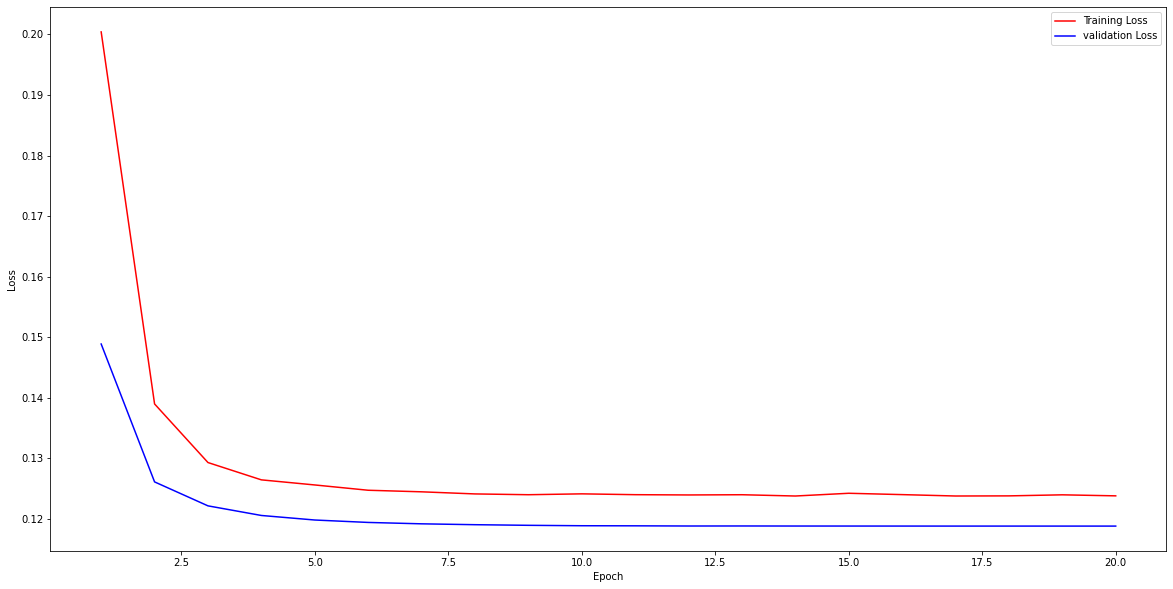

In [111]:
epochs = range(1, 21)
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(epochs, training_loss, 'r-')
plt.plot(epochs, validation_loss, 'b-')
plt.legend(['Training Loss', 'validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

### Package the model using MLFLOW

Now that we have trained and validated the model, it's time to package it. We will need to do the following:
1. Serialize the tokenizer, the embeddings matrix, the model's weights.
2. Define the dictionary artifact that contains the file path of the serialized objects.
3. Define the Conda environment with all the dependencies.
4. Define the PythonModel class, which includes the 'predict' function logic.

In [0]:
# install mlflow
%%capture
!pip install mlflow

In [0]:
#useful import
import mlflow
import mlflow.pyfunc
import keras
import tensorflow
import nltk

In [0]:
# serialize both the tokenizer and the embeddings to be included in our package
import pickle
tokenizer_path = f'/content/tokenizer.pkl'
embeddings_path = f'/content/embeddings.pkl'

with open(tokenizer_path, 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(embeddings_path, 'wb') as handle:
    pickle.dump(embedding_matrix, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Define the artifacts

In [0]:
# prepare the artifacts
state_dict_path = f'/content/state_dict_best_model.pt'
artifacts = {
    "state_dict_model": state_dict_path,
    "embeddings": embeddings_path,
    "tokenizer": tokenizer_path,
}

### Define our conda_env

In [0]:
# prepare the conda environment
conda_env = {
    'channels': ['defaults'],
    'dependencies': [
            f'python=3.6.9',
      {
          'pip':[
            f'mlflow=={mlflow.__version__}',
            f'torch=={torch.__version__}',
            f'keras=={keras.__version__}',
            f'tensorflow=={tensorflow.__version__}',
            f'cloudpickle==1.3.0',
            f'nltk=={nltk.__version__}'              
    ]
      }
    ],
    'name': 'toxicity-env'
}

### Define the model wrapper

In [0]:
class ModelWrapper(mlflow.pyfunc.PythonModel):

  def load_context(self, context):
    from model import NeuralNet
    from config import NUM_AUX_TARGET

    # Load in and deserialize the embeddings
    with open(context.artifacts["embeddings"], 'rb') as handle:
      self._embedding_model = pickle.load(handle)
    
    # load in and deserialize the model tokenizer
    with open(context.artifacts["tokenizer"], 'rb') as handle:
      self._model_tokenizer = pickle.load(handle)
      
    self._model = NeuralNet(self._embedding_model, NUM_AUX_TARGET)
    self._model.load_state_dict(torch.load(context.artifacts["state_dict_model"], map_location="cpu"))
    self._model.eval()
    
  def predict(self, context, input_model):
    from preprocessing import preprocess
    from utils import sigmoid
    import pandas as pd
    from keras.preprocessing.sequence import pad_sequences
    import numpy as np


    sentence = input_model.iloc[0]['sentence']
    sentence = preprocess(sentence)
    sentence_tokens = self._model_tokenizer.texts_to_sequences([sentence])
    sentence_tokens = pad_sequences(sentence_tokens, 100)
    
    inputs = torch.tensor(sentence_tokens)
    inputs = inputs.type(torch.LongTensor)
    inputs = inputs.to("cpu")
    model_pred = self._model(inputs).detach().cpu().numpy()
    predictions = sigmoid(model_pred)
    pred_results = predictions[0].tolist()
    results = {
        "toxicity_score": [pred_results[0]],
        "target": [pred_results[1]],
        "severe_toxicity": [pred_results[2]],
        "obscene": [pred_results[3]],
        "identity_attack": [pred_results[4]],
        "insult": [pred_results[5]],
        "threat": [pred_results[6]]
    }
    return pd.DataFrame.from_dict(results)


In [0]:
## Package the model
# Location in our gdrive where we want the model to be saved
model_path = f"/content/drive/My Drive/toxicity_models/model"



# Package the model!
mlflow.pyfunc.save_model(path=model_path,
                         python_model=ModelWrapper(),
                         artifacts=artifacts,
                         conda_env=conda_env,
                         code_path=['/content/model.py', '/content/preprocessing.py',
                                    '/content/config.py','/content/utils.py', '/content/meta_data.txt'])

## Load the model and make predictions

In [0]:
model = mlflow.pyfunc.load_model(model_path)

In [0]:
data = {'sentence':["How can a dummy dope like Harry Hurt, who wrote a failed book about me but doesn’t know me or anything about me, be on TV discussing Trump?"]}

In [0]:
data_df = pd.DataFrame(data)

In [127]:
model.predict(data_df)

,toxicity_score,target,severe_toxicity,obscene,identity_attack,insult,threat
0,0.111781,0.174091,0.005617,0.017647,0.027676,0.125623,0.01211


In [128]:
data = {"sentence":["Truly weird Senator Rand Paul of Kentucky reminds me of a spoiled brat without a properly functioning brain. He was terrible at DEBATE!"]}
data_df = pd.DataFrame(data)
model.predict(data_df)

,toxicity_score,target,severe_toxicity,obscene,identity_attack,insult,threat
0,0.442497,0.403986,0.019712,0.061419,0.062199,0.346573,0.027996


In [129]:
data = {"sentence":[".@MeghanMcCain was terrible on @TheFive yesterday. Angry and obnoxious, she will never make it on T.V. @FoxNews can do so much better!"]}
data_df = pd.DataFrame(data)
model.predict(data_df)


,toxicity_score,target,severe_toxicity,obscene,identity_attack,insult,threat
0,0.17153,0.224021,0.006515,0.021521,0.03267,0.170186,0.012993


In [130]:
data = {"sentence":[".@FrankLuntz is a low class slob who came to my office looking for consulting work and I had zero interest. Now he picks anti-Trump panels!"]}
data_df = pd.DataFrame(data)
model.predict(data_df)


,toxicity_score,target,severe_toxicity,obscene,identity_attack,insult,threat
0,0.009807,0.033485,0.001609,0.003656,0.008026,0.022197,0.005752


In [131]:
data = {"sentence":["what an asshole"]}
data_df = pd.DataFrame(data)
model.predict(data_df)

,toxicity_score,target,severe_toxicity,obscene,identity_attack,insult,threat
0,0.862094,0.685203,0.045963,0.156498,0.093172,0.664564,0.042097


In [132]:
data = {"sentence":["Stupid motherfucker"]}
data_df = pd.DataFrame(data)
model.predict(data_df)

,toxicity_score,target,severe_toxicity,obscene,identity_attack,insult,threat
0,0.845771,0.674069,0.048841,0.159775,0.094412,0.651984,0.045888


The model can be improved by training it on more data.
The packaged model can be integrated within a REST API for real-time serving.